In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import faiss
import time
from mpl_toolkits.mplot3d import Axes3D

# FAISS (Facebook AI Similarity Search)

In [2]:
# This code demonstrates three different approaches to vector similarity search:
# 1. Manual brute force cosine similarity (pure Python/NumPy)
# 2. FAISS IndexFlatL2 (exact search, but optimized)
# 3. FAISS IndexIVF (approximate search using clustering)

# Key FAISS Concepts:
# - Index: A data structure that holds vectors and enables fast searching
# - IndexFlatL2: Brute force L2 distance search (exact but slower for large datasets)
# - IndexIVF: Uses clustering to speed up search (approximate but much faster)
# - Training: Teaching the index how to partition the vector space
# - nprobe: How many clusters to search (trade-off between speed and accuracy)

In [3]:
def generate_sample_vectors(n_vectors=100, n_dimensions=3, seed=42):
    """
    Generate synthetic vectors for demonstration.
    
    In real applications, these vectors would be:
    - Text embeddings from sentences/documents
    - Image features from neural networks
    - Product features for recommendation systems
    - Any high-dimensional data you want to search
    """
    np.random.seed(seed)
    vectors = np.random.randn(n_vectors, n_dimensions)
    # Normalize to unit length - important for cosine similarity
    normalized_vectors = normalize(vectors, norm='l2')
    return normalized_vectors

def plot_vectors_3d(vectors, query_vector=None, matches=None, title="Vector Space Visualization"):
    """
    Visualize vectors in 3D space (only works for 3D vectors).
    This helps understand what similarity search is doing geometrically.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot all database vectors as blue dots
    ax.scatter(vectors[:, 0], vectors[:, 1], vectors[:, 2], c='blue', alpha=0.5, label='Database vectors')
    
    # Plot query vector as a red dot - this is what we're searching for
    if query_vector is not None:
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], 
                  c='red', s=100, label='Query vector')
    
    # Plot matching vectors as green dots - these are the closest matches found
    if matches is not None:
        match_vectors = vectors[matches]
        ax.scatter(match_vectors[:, 0], match_vectors[:, 1], match_vectors[:, 2], 
                  c='green', s=100, label='Matches')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

def plot_vectors_with_regions(vectors, centroids, query_vector=None, matches=None, 
                            searched_regions=None, title="Vector Space with FAISS Regions"):
    """
    Visualize how FAISS IVF partitions the vector space into regions.
    
    Key insight: IVF doesn't search ALL vectors, only those in selected regions.
    This is why it's faster but potentially less accurate.
    """
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111, projection='3d')
    
    # Assign each vector to its nearest centroid (region)
    distances, assignments = compute_vector_assignments(vectors, centroids)
    
    # Color-code vectors by their region
    colors = plt.cm.rainbow(np.linspace(0, 1, len(centroids)))
    for i in range(len(centroids)):
        cluster_vectors = vectors[assignments == i]
        if len(cluster_vectors) > 0:
            # Highlight searched regions vs unsearched regions
            # Unsearched regions are made transparent to show IVF only searches some areas
            alpha = 1.0 if searched_regions is None or i in searched_regions else 0.1
            ax.scatter(cluster_vectors[:, 0], cluster_vectors[:, 1], cluster_vectors[:, 2], 
                      c=[colors[i]], alpha=alpha, label=f'Region {i}')
    
    # Plot region centers (centroids) as black stars
    ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
              c='black', s=100, marker='*', label='Region Centers')
    
    # Plot query vector as red X
    if query_vector is not None:
        ax.scatter(query_vector[0], query_vector[1], query_vector[2], 
                  c='red', s=200, marker='x', label='Query Vector')
    
    # Plot matches as green dots
    if matches is not None:
        match_vectors = vectors[matches]
        ax.scatter(match_vectors[:, 0], match_vectors[:, 1], match_vectors[:, 2], 
                  c='green', s=100, label='Matches')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(title)
    ax.legend()
    plt.show()

def compute_vector_assignments(vectors, centroids):
    """
    Figure out which vectors belong to which region.
    This uses FAISS internally to find nearest centroids efficiently.
    """
    index = faiss.IndexFlatL2(vectors.shape[1])
    index.add(centroids)
    distances, assignments = index.search(vectors, 1)
    return distances, assignments.ravel()

def train_kmeans_get_centroids(vectors, n_clusters):
    """
    Train k-means clustering to get region centers.
    FAISS has its own k-means implementation optimized for high dimensions.
    """
    kmeans = faiss.Kmeans(d=vectors.shape[1], k=n_clusters, niter=20, verbose=False)
    kmeans.train(vectors)
    return kmeans.centroids

In [4]:
def brute_force_cosine_search(database_vectors, query_vector, k=5):
    """
    Manual implementation of cosine similarity search.
    
    How it works:
    1. Compute cosine similarity between query and ALL database vectors
    2. Sort by similarity score
    3. Return top-k matches
    
    Pros: Exact results, simple to understand
    Cons: Slow for large datasets (O(n) complexity)
    """
    start_time = time.time()
    
    # Compute cosine similarity: dot product of normalized vectors
    similarities = np.dot(database_vectors, query_vector)
    
    # Get indices of top-k most similar vectors
    top_k_indices = np.argsort(similarities)[-k:][::-1]  # Sort descending
    
    end_time = time.time()
    return top_k_indices, end_time - start_time

def faiss_flat_l2_search(database_vectors, query_vector, k=5):
    """
    FAISS IndexFlatL2: Exact search but optimized implementation.
    
    How it works:
    1. Uses L2 (Euclidean) distance instead of cosine similarity
    2. Still searches ALL vectors (brute force)
    3. But uses optimized C++ implementation and SIMD instructions
    
    Key difference from manual cosine:
    - L2 distance vs cosine similarity (related but not identical)
    - Much faster implementation
    - Still exact results
    
    Note: For normalized vectors, L2 distance ranking ≈ cosine similarity ranking
    """
    dimension = database_vectors.shape[1]
    
    # Create a "flat" index - stores all vectors in a simple array
    index = faiss.IndexFlatL2(dimension)
    
    start_time = time.time()
    
    # Add all database vectors to the index
    index.add(database_vectors)
    
    # Search for k nearest neighbors
    # Returns: distances (L2 distances) and indices (vector positions)
    distances, indices = index.search(query_vector.reshape(1, -1), k)
    
    end_time = time.time()
    
    return indices[0], end_time - start_time

def faiss_ivf_search(database_vectors, query_vectors, k=5, n_regions=10, nprobe=3):
    """
    FAISS IndexIVF: Approximate search using clustering.
    
    How it works:
    1. TRAINING: Divide vector space into n_regions using k-means clustering
    2. INDEXING: Assign each database vector to its nearest region
    3. SEARCHING: 
       - Find nprobe closest regions to query vector
       - Only search vectors in those regions (ignore others!)
       - This is why it's faster but potentially less accurate
    
    Key parameters:
    - n_regions: More regions = finer partitioning = potentially better accuracy but more overhead
    - nprobe: More probes = search more regions = better accuracy but slower
    
    Typical settings:
    - n_regions: sqrt(N) to N/100 where N is number of vectors
    - nprobe: 1-10% of n_regions
    """
    dimension = database_vectors.shape[1]
    
    # Step 1: Create the index structure
    # quantizer: Used to determine which region each vector belongs to
    quantizer = faiss.IndexFlatL2(dimension)
    # The actual IVF index: quantizer + number of regions + distance metric
    index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)
    
    # Step 2: TRAINING - Learn how to partition the vector space
    print("Training index (this is usually done once)...")
    train_start = time.time()
    # This runs k-means to find region centroids
    index.train(database_vectors)
    train_time = time.time() - train_start
    
    # Step 3: INDEXING - Add vectors to their appropriate regions
    add_start = time.time()
    # Each vector gets assigned to its nearest region
    index.add(database_vectors)
    add_time = time.time() - add_start
    
    # Step 4: Configure search parameters
    # nprobe: How many regions to search (trade-off between speed and accuracy)
    index.nprobe = nprobe
    
    # Step 5: SEARCHING - The actual similarity search
    search_start = time.time()
    # This only searches vectors in the nprobe closest regions
    distances, indices = index.search(query_vectors, k)
    search_time = time.time() - search_start
    
    return indices, search_time, train_time, add_time

Generating 1000 vectors with 3 dimensions...

Visualizing initial vector space...


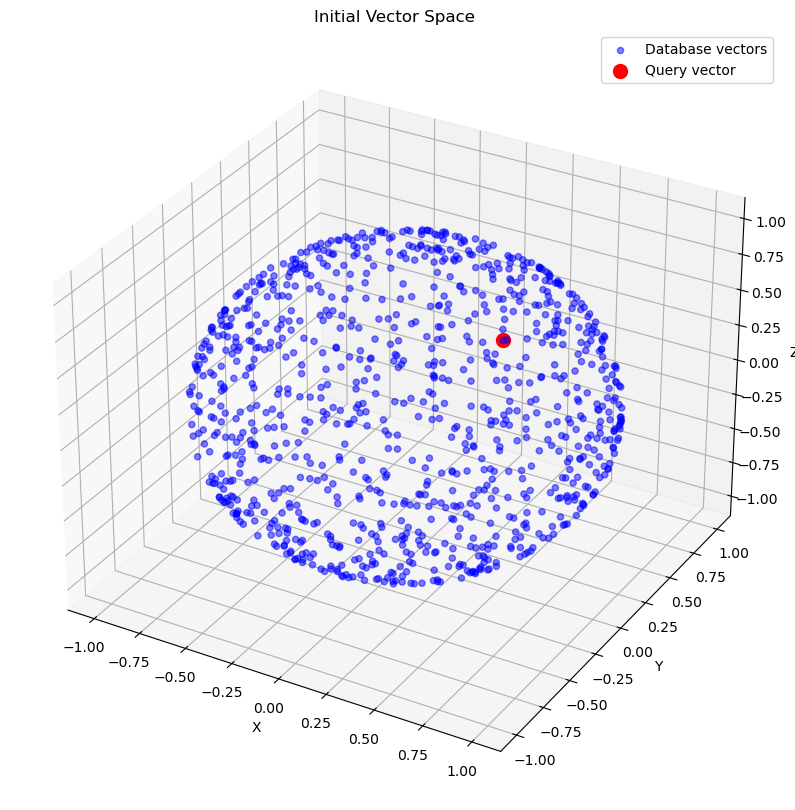

In [5]:
# 1. Generate sample data for visualization
n_vectors = 1000
n_dimensions = 3  # Using 3D so we can visualize the vector space
k = 5  # Find 5 most similar vectors
print(f"Generating {n_vectors} vectors with {n_dimensions} dimensions...")
database_vectors = generate_sample_vectors(n_vectors, n_dimensions)

# 2. Create a query vector - this is what we want to find similar vectors for
query_vector = generate_sample_vectors(1, n_dimensions)[0]
query_vector_batch = query_vector.reshape(1, -1)  # Reshape for batch processing

# 3. Visualize the initial vector space
print("\nVisualizing initial vector space...")
plot_vectors_3d(database_vectors, query_vector, title="Initial Vector Space")


METHOD 1: BRUTE FORCE COSINE SIMILARITY
This searches ALL vectors using manual cosine similarity calculation
Search time: 0.000000 seconds
Top 5 matches (indices): [  0 653  61 273 336]


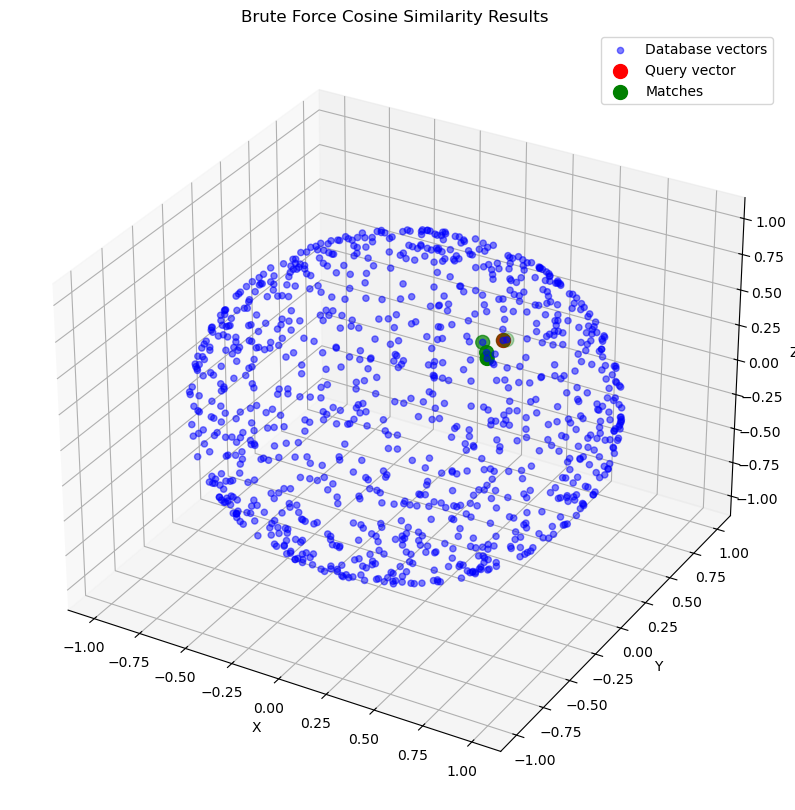

In [6]:
print("\n" + "="*60)
print("METHOD 1: BRUTE FORCE COSINE SIMILARITY")
print("="*60)
print("This searches ALL vectors using manual cosine similarity calculation")

cosine_matches, cosine_time = brute_force_cosine_search(database_vectors, query_vector, k)
print(f"Search time: {cosine_time:.6f} seconds")
print(f"Top {k} matches (indices): {cosine_matches}")

# Visualize results
plot_vectors_3d(database_vectors, query_vector, cosine_matches, 
               "Brute Force Cosine Similarity Results")


METHOD 2: FAISS FLAT L2 (EXACT SEARCH)
This searches ALL vectors but uses optimized FAISS implementation
Search time: 0.001000 seconds
Top 5 matches (indices): [  0 653  61 273 336]


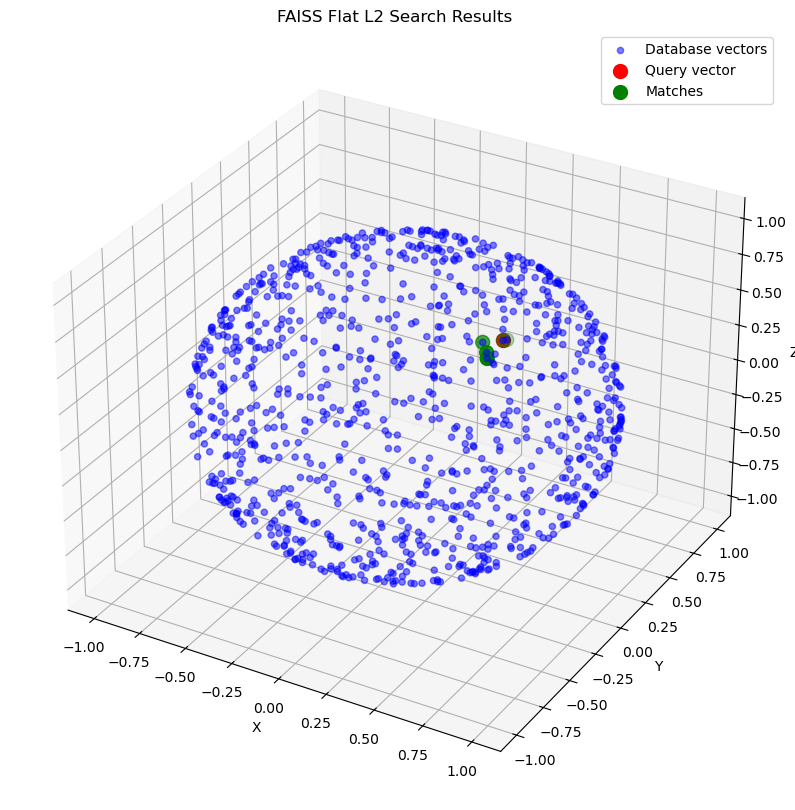

In [7]:
print("\n" + "="*60)
print("METHOD 2: FAISS FLAT L2 (EXACT SEARCH)")
print("="*60)
print("This searches ALL vectors but uses optimized FAISS implementation")

faiss_matches, faiss_time = faiss_flat_l2_search(database_vectors, query_vector, k)
print(f"Search time: {faiss_time:.6f} seconds")
print(f"Top {k} matches (indices): {faiss_matches}")
# print(f"Speed improvement over brute force: {cosine_time/faiss_time:.1f}x") # Devision by zero

# Visualize results
plot_vectors_3d(database_vectors, query_vector, faiss_matches, 
               "FAISS Flat L2 Search Results")


METHOD 3: FAISS IVF (APPROXIMATE SEARCH)
This only searches vectors in selected regions - much faster!
Training: Learning how to divide 1000 vectors into 10 regions...
Training time: 0.002997 seconds
Indexing: Assigning each vector to its nearest region...
Indexing time: 0.001001 seconds
Search configuration: Will search 3 out of 10 regions
Searching: Looking for similar vectors in selected regions only...
Search time: 0.000000 seconds
Total time (train + index + search): 0.003998 seconds
Search-only time: 0.000000 seconds
Searched regions: [4 2 3] (out of [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


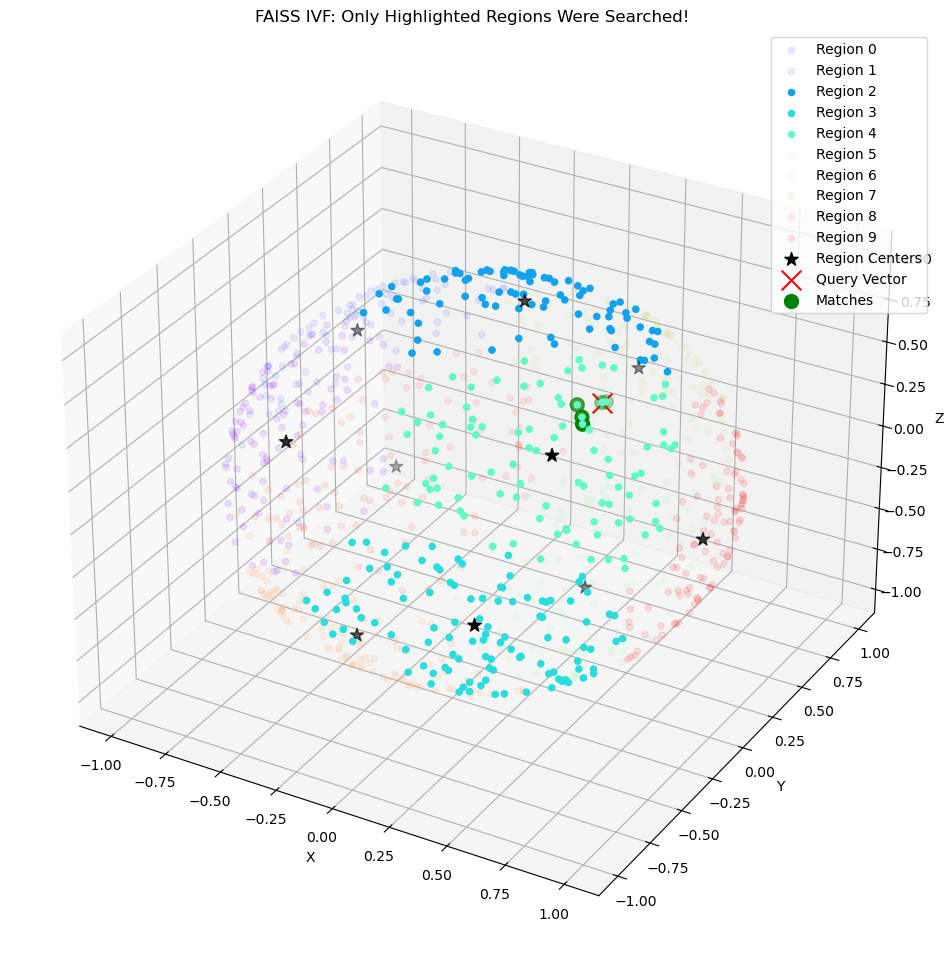

In [8]:
print("\n" + "="*60)
print("METHOD 3: FAISS IVF (APPROXIMATE SEARCH)")
print("="*60)
print("This only searches vectors in selected regions - much faster!")

n_regions = 10  # Divide space into 10 regions
nprobe = 3      # Search only 3 closest regions

# Create and configure IVF index
dimension = database_vectors.shape[1]
quantizer = faiss.IndexFlatL2(dimension)
index = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)

# Training phase - learn how to partition the space
print(f"Training: Learning how to divide {n_vectors} vectors into {n_regions} regions...")
train_start = time.time()
index.train(database_vectors)
train_time = time.time() - train_start
print(f"Training time: {train_time:.6f} seconds")

# Indexing phase - assign vectors to regions
print("Indexing: Assigning each vector to its nearest region...")
add_start = time.time()
index.add(database_vectors)
add_time = time.time() - add_start
print(f"Indexing time: {add_time:.6f} seconds")

# Configure search parameters
index.nprobe = nprobe
print(f"Search configuration: Will search {nprobe} out of {n_regions} regions")

# Search phase - find similar vectors
print("Searching: Looking for similar vectors in selected regions only...")
search_start = time.time()
distances, ivf_matches = index.search(query_vector_batch, k)
search_time = time.time() - search_start
ivf_matches = ivf_matches[0]  # Get first batch result

print(f"Search time: {search_time:.6f} seconds")
print(f"Total time (train + index + search): {train_time + add_time + search_time:.6f} seconds")
print(f"Search-only time: {search_time:.6f} seconds")

# Show which regions were searched
_, searched_regions = quantizer.search(query_vector_batch, nprobe)
searched_regions = searched_regions[0]
print(f"Searched regions: {searched_regions} (out of {list(range(n_regions))})")

# Get centroids for visualization
centroids = train_kmeans_get_centroids(database_vectors, n_regions)

# Visualize IVF results with regions highlighted
plot_vectors_with_regions(
    database_vectors, 
    centroids,
    query_vector, 
    ivf_matches,
    searched_regions,
    "FAISS IVF: Only Highlighted Regions Were Searched!"
)

In [9]:
print("\n" + "="*60)
print("RESULTS COMPARISON")
print("="*60)

# Compare which matches were found by each method
common_matches_basic = set(cosine_matches).intersection(set(faiss_matches))
common_matches_ivf = set(cosine_matches).intersection(set(ivf_matches))

print("Match overlap analysis:")
print(f"Cosine vs FAISS Flat: {len(common_matches_basic)}/{k} matches in common")
print(f"Common indices: {sorted(common_matches_basic)}")
print(f"Cosine vs FAISS IVF: {len(common_matches_ivf)}/{k} matches in common")
print(f"Common indices: {sorted(common_matches_ivf)}")

if len(common_matches_ivf) < k:
    print(f"\nNote: IVF found different results because it only searched {nprobe}/{n_regions} regions")
    print("This is the trade-off: speed vs accuracy")


RESULTS COMPARISON
Match overlap analysis:
Cosine vs FAISS Flat: 5/5 matches in common
Common indices: [np.int64(0), np.int64(61), np.int64(273), np.int64(336), np.int64(653)]
Cosine vs FAISS IVF: 5/5 matches in common
Common indices: [np.int64(0), np.int64(61), np.int64(273), np.int64(336), np.int64(653)]


In [38]:
print("\n" + "="*60)
print("PERFORMANCE TESTING")
print("="*60)
print("Testing how each method scales with dataset size...")

# Test with different vector database sizes
vector_sizes = [100, 1000, 10000, 100000]
n_queries = 1000  # Test with 1000 queries each time
k = 5
dimension = 128  # Higher dimension, more realistic

# Storage for results
results = {
    'sizes': vector_sizes,
    'brute_force': [],
    'faiss_flat': [],
    'faiss_ivf': []
}

for size in vector_sizes:
    print(f"\nTesting with {size:,} database vectors and {n_queries:,} queries...")
    
    # Generate test data
    vectors = generate_sample_vectors(size, dimension)
    query_vectors = generate_sample_vectors(n_queries, dimension)
    
    # 1. Test Brute Force Cosine (slowest, skip for very large datasets)
    if size <= 10000:  # Skip brute force for largest dataset
        start_time = time.time()
        for query in query_vectors:
            _, _ = brute_force_cosine_search(vectors, query, k)
        brute_force_time = (time.time() - start_time) / n_queries
        results['brute_force'].append(brute_force_time)
    else:
        results['brute_force'].append(np.nan)  # Too slow to test
    
    # 2. Test FAISS Flat L2
    index_flat = faiss.IndexFlatL2(dimension)
    index_flat.add(vectors)
    
    start_time = time.time()
    distances, indices = index_flat.search(query_vectors, k)
    faiss_flat_time = (time.time() - start_time) / n_queries
    results['faiss_flat'].append(faiss_flat_time)
    
    # 3. Test FAISS IVF
    n_regions = min(size // 100, 1000)  # Adaptive number of regions
    nprobe = max(1, n_regions // 10)    # Search ~10% of regions
    
    # Create and train IVF index
    quantizer = faiss.IndexFlatL2(dimension)
    index_ivf = faiss.IndexIVFFlat(quantizer, dimension, n_regions, faiss.METRIC_L2)
    index_ivf.train(vectors)
    index_ivf.add(vectors)
    index_ivf.nprobe = nprobe
    
    # Time only the search phase (training is one-time cost)
    start_time = time.time()
    distances, indices = index_ivf.search(query_vectors, k)
    faiss_ivf_time = (time.time() - start_time) / n_queries
    results['faiss_ivf'].append(faiss_ivf_time)
    
    # Print results for this size
    print(f"Average time per query:")
    if not np.isnan(results['brute_force'][-1]):
        print(f"  Brute Force:  {results['brute_force'][-1]:.6f} seconds")
    else:
        print(f"  Brute Force:  (too slow to test)")
    print(f"  FAISS Flat:   {faiss_flat_time:.6f} seconds")
    print(f"  FAISS IVF:    {faiss_ivf_time:.6f} seconds")
    print(f"  IVF speedup:  {faiss_flat_time/faiss_ivf_time:.1f}x faster than Flat")


PERFORMANCE TESTING
Testing how each method scales with dataset size...

Testing with 100 database vectors and 1,000 queries...
Average time per query:
  Brute Force:  0.000007 seconds
  FAISS Flat:   0.000001 seconds
  FAISS IVF:    0.000002 seconds
  IVF speedup:  0.5x faster than Flat

Testing with 1,000 database vectors and 1,000 queries...
Average time per query:
  Brute Force:  0.000062 seconds
  FAISS Flat:   0.000002 seconds
  FAISS IVF:    0.000002 seconds
  IVF speedup:  1.0x faster than Flat

Testing with 10,000 database vectors and 1,000 queries...
Average time per query:
  Brute Force:  0.000548 seconds
  FAISS Flat:   0.000014 seconds
  FAISS IVF:    0.000006 seconds
  IVF speedup:  2.3x faster than Flat

Testing with 100,000 database vectors and 1,000 queries...
Average time per query:
  Brute Force:  (too slow to test)
  FAISS Flat:   0.000124 seconds
  FAISS IVF:    0.000145 seconds
  IVF speedup:  0.9x faster than Flat



Creating performance comparison chart...


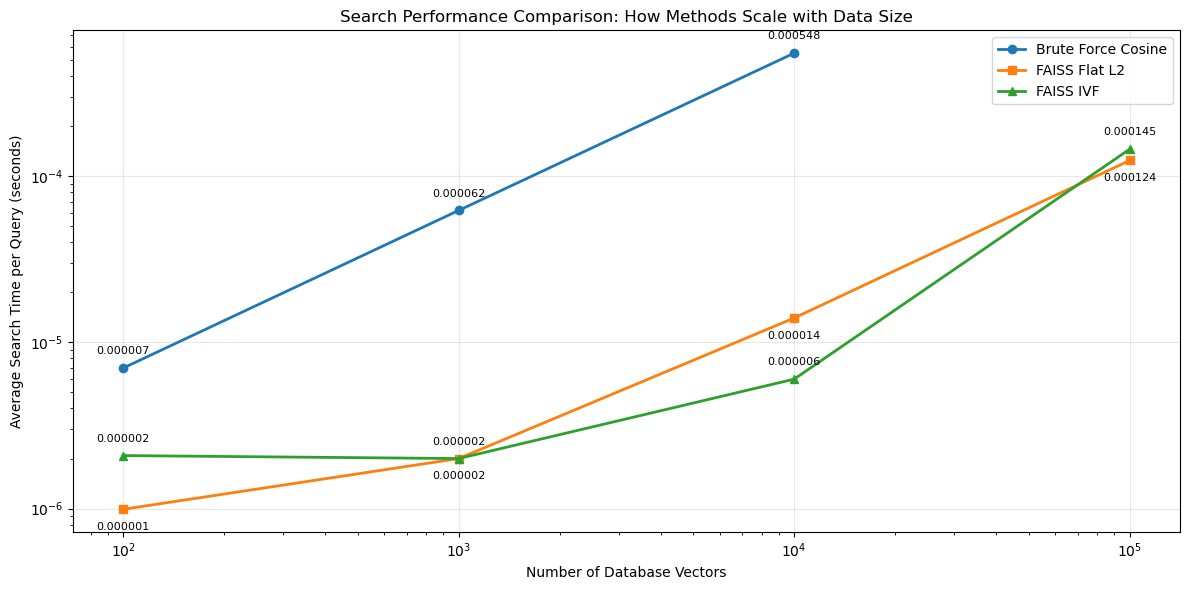

In [39]:
print("\nCreating performance comparison chart...")

plt.figure(figsize=(12, 6))

# Plot results (handle NaN values for brute force)
valid_brute = [x for x in results['brute_force'] if not np.isnan(x)]
valid_sizes_brute = [results['sizes'][i] for i, x in enumerate(results['brute_force']) if not np.isnan(x)]

if valid_brute:
    plt.plot(valid_sizes_brute, valid_brute, 'o-', label='Brute Force Cosine', linewidth=2)
plt.plot(results['sizes'], results['faiss_flat'], 's-', label='FAISS Flat L2', linewidth=2)
plt.plot(results['sizes'], results['faiss_ivf'], '^-', label='FAISS IVF', linewidth=2)

plt.xscale('log')  # Log scale for x-axis (vector counts)
plt.yscale('log')  # Log scale for y-axis (time)

plt.xlabel('Number of Database Vectors')
plt.ylabel('Average Search Time per Query (seconds)')
plt.title('Search Performance Comparison: How Methods Scale with Data Size')
plt.grid(True, alpha=0.3)
plt.legend()

# Add annotations showing exact values
for i, size in enumerate(results['sizes']):
    if i < len(valid_brute):
        plt.annotate(f'{valid_brute[i]:.6f}', 
                    (valid_sizes_brute[i], valid_brute[i]), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)
    
    plt.annotate(f'{results["faiss_flat"][i]:.6f}', 
                (size, results['faiss_flat'][i]), 
                textcoords="offset points", xytext=(0,-15), ha='center', fontsize=8)
    
    plt.annotate(f'{results["faiss_ivf"][i]:.6f}', 
                (size, results['faiss_ivf'][i]), 
                textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.show()

In [12]:
# 1. FAISS IndexFlatL2:
#    - Exact search, but much faster than manual implementation
#    - Good for small to medium datasets (< 1M vectors)
#    - Use when you need perfect accuracy

# 2. FAISS IndexIVF:
#    - Approximate search using clustering
#    - Much faster for large datasets (> 100K vectors)
#    - Trade-off: speed vs accuracy (controlled by nprobe parameter)
#    - Requires one-time training cost

# 3. When to use what:
#    - Small dataset (< 10K): Any method works
#    - Medium dataset (10K - 1M): IndexFlatL2
#    - Large dataset (> 1M): IndexIVF with appropriate nprobe

# 4. IVF Key Parameters:
#    - n_regions: More regions = finer partitioning (try sqrt(N) to N/100)
#    - nprobe: More probes = better accuracy but slower (try 1-10% of n_regions)

# 5. Real-world usage:
#    - Train index once, save it to disk
#    - Load saved index for fast searching
#    - Batch queries when possible for better performance